# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [137]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, preprocessing, model_selection
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile

Итак, прочитаем нашу таблицу:

In [138]:
with ZipFile('data/churn.zip') as myzip:
    churn_data = pd.read_csv(myzip.open('churn.csv'), index_col='RowNumber')
churn_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [139]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


Всего 12 признаков и целевая переменная. Очевидных пропусков нет. 9 признаков числовых и 3 типа object.

Смотрим на сбалансированность классов:

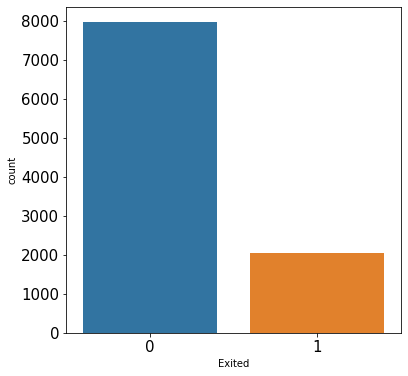

In [140]:
fig = plt.subplots(figsize=(6, 6))
sns.countplot(data=churn_data, x='Exited');

Классы несбалансированы, для оценки качества модели к accuracy нужно добавить метрики precision и recall.

Посмотрим на распределение числовых признаков и их связь с целевым показателем.

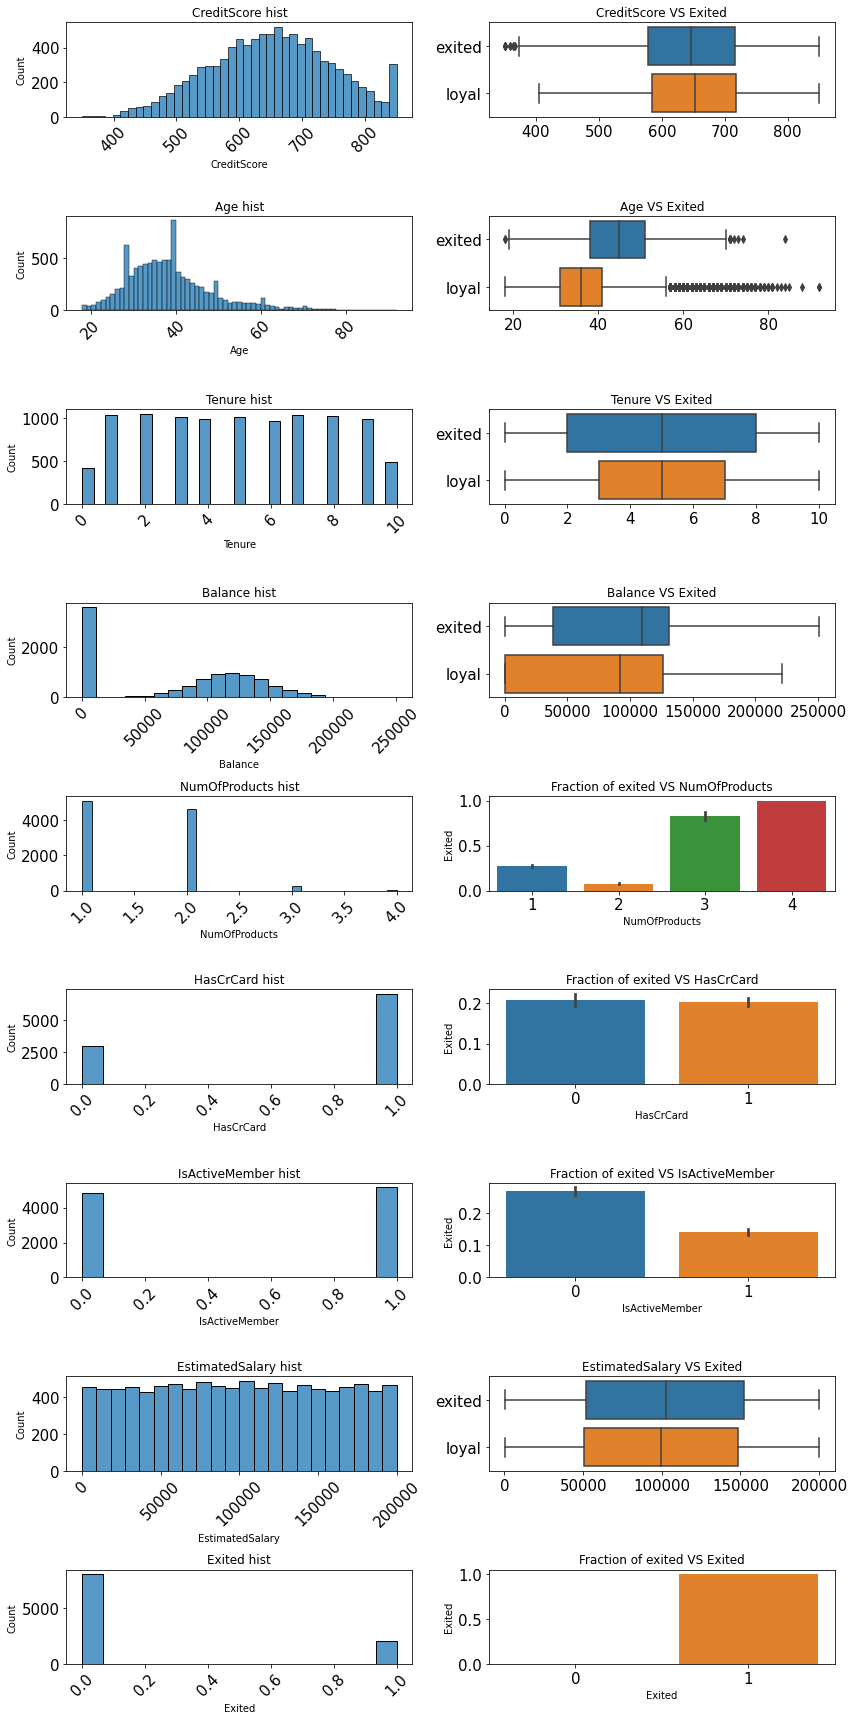

In [141]:
num_features = list(churn_data.dtypes[(churn_data.dtypes != 'object')].index.drop('CustomerId'))
n = len(num_features)
fig, axes = plt.subplots(n, 2, figsize=(12, 24))
for i, feature in enumerate(num_features):
    histplot = sns.histplot(data=churn_data, x=feature, ax=axes[i][0])
    histplot.set_title('{} hist'.format(feature))
    histplot.xaxis.set_tick_params(rotation=45)
    if churn_data[feature].nunique() > 4:
        zero = churn_data[churn_data['Exited'] == 0][feature]
        uno = churn_data[churn_data['Exited'] == 1][feature]
        zu = pd.DataFrame({'exited': uno, 'loyal': zero})
        boxpl = sns.boxplot(data=zu, orient='h', ax=axes[i][1])
        boxpl.set_title('{} VS Exited'.format(feature))
    else:
        mean_barplot = sns.barplot(data=churn_data, x=feature, y='Exited', ax=axes[i][1])
        mean_barplot.set_title('Fraction of exited VS {}'.format(feature))
plt.tight_layout();

Посмотрим на нечисловые признаки:

In [142]:
churn_data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


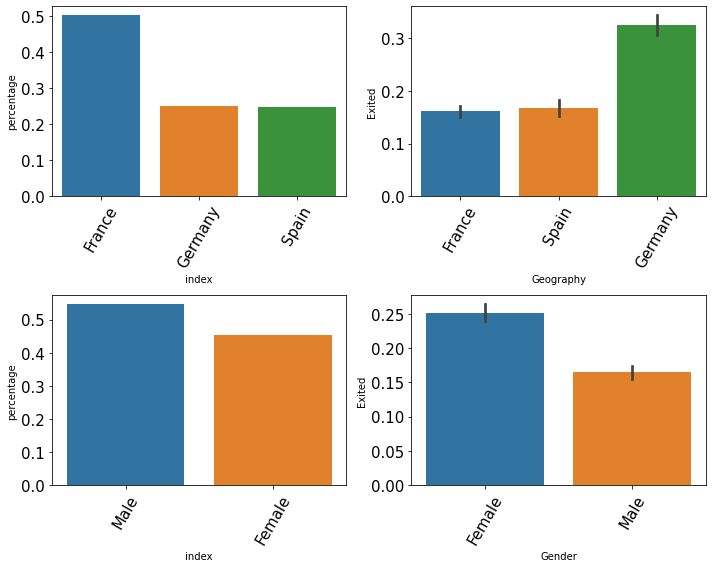

In [143]:
cat_features = list(churn_data.dtypes[(churn_data.dtypes == 'object')].index.drop('Surname'))
n = len(cat_features)
fig, axes = plt.subplots(n, 2, figsize=(10, 8))
# Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    # Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (churn_data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    # Строим столбчатую диаграмму, отражающую долю ушедших клиентов в категории
    mean_barplot = sns.barplot(data=churn_data, x=feature, y='Exited', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout()

У признака Surname слишком много уникальных значений, этот признак исключаем из рассмотрения так же как и CustomerId.

Больше всего данных собрано во Франции, доля ушедших клиентов в Германии существенно выше, чем во Франции и Испании.

Количество клиентов мужского пола превышает количество клиентов-женщин. При этом среди ушедших клиентов доля женщин выше.

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [144]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 13)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

И переведем категориальный признак Gender в бинарный числовой.

In [145]:
churn_data = churn_data.drop(['Geography', 'CustomerId', 'Surname'], axis=1)
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,
8,376,0,29,4,115046.74,4,1,0,119346.88,1
16,616,1,45,3,143129.41,2,0,1,64327.26,0
17,653,1,58,1,132602.88,1,1,0,5097.67,1
27,756,1,36,2,136815.64,1,1,1,170041.95,0
29,574,0,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет дубликатов:

In [146]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

Для выполнения деления на значения признаков заработная плата и возраст клиента убедимся, что в этих столбцах нет скрытых пропусков в виде значения равного 0.

In [147]:
print(churn_data[churn_data['EstimatedSalary'] == 0]['EstimatedSalary'].count(), 'нулевых значений в признаке зарплата')
print(churn_data[churn_data['Age'] == 0]['Age'].count(), 'нулевых значений в признаке возраст')

0 нулевых значений в признаке зарплата
0 нулевых значений в признаке возраст


Библиотека pandas позволяет выполнять действия непосредственно со столбцами, в том числе для нахождения отношения одного признака к другому.

Единственный оставшийся категориальный признак Gender приведен к числовому бинарному виду еще в п.5.0.

Выведем основные статистические показатели числовых признаков.

In [148]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']
churn_data.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,0.524512,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487
std,98.168937,0.499498,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558
min,350.000000,0.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676
25%,584.000000,0.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275
50%,651.000000,1.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143
75%,722.000000,1.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941
max,850.000000,1.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889


И посмотрим на корреляцию признаков между собой и с таргетом.

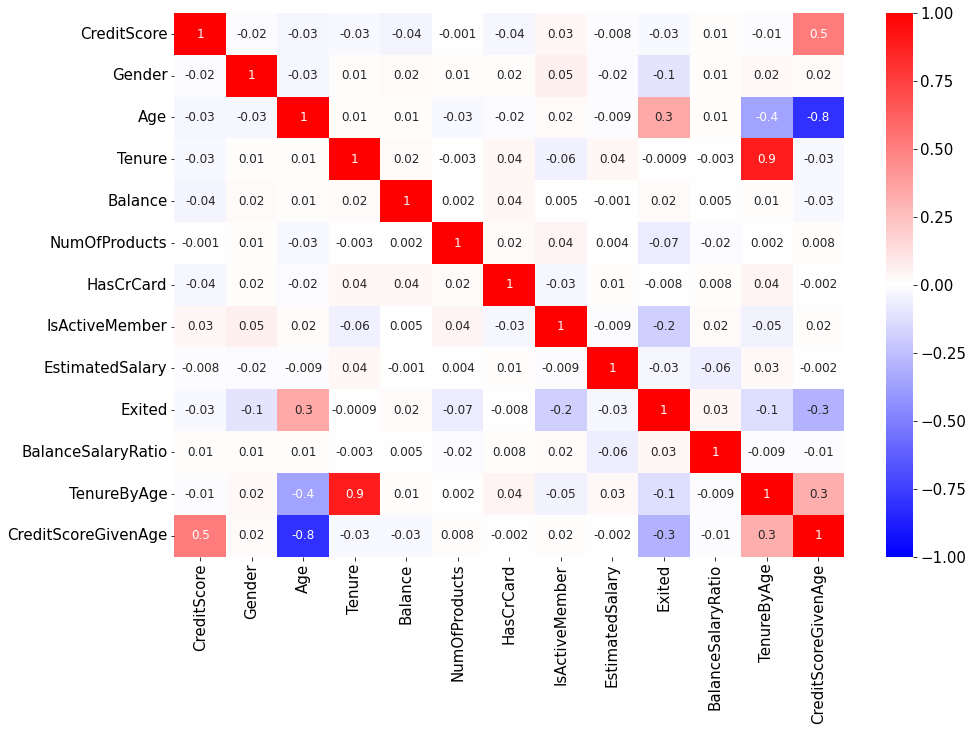

In [149]:
# строим тепловую карту корреляций
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
sns.heatmap(churn_data.corr(), annot=True, annot_kws={"fontsize":12}, fmt='.1g',
            vmin=-1, vmax=1, center= 0, cmap= 'bwr');

Из первоначальных признаков самую высокую корреляцию с таргетом показывает признак Age. Корреляции добавленных признаков определены способом их получения.

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [150]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [151]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [152]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [153]:
print('Train :')
display(y_train.value_counts(normalize=True))
print()
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Для нормализации используем MinMaxScaler, т.к. этот метод не смещает бинарные признаки, такие как пол, наличие карты, активный статус.

In [154]:
# Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
# Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
# Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Метрика Precision -	доля объектов действительно положительных по отношению ко всем объектам, названным моделью положительными. Улучшение данной метрики позволяет уменьшить ложноположительные результаты.
>
> Метрика Recall - доля объектов, верно названных моделью положительными, по отношению ко всем объектам положительного класса. Эту метрику можно использовать для уменьшения ложноотрицательных результатов.
>
> Т.к. нас интересует оптимизация обоих показателей, возмем взвешенное среднее гармоническое этих метрик - метрику $F_1$.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [155]:
log_reg = linear_model.LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)
print('Метрики на тренировочных данных')
print(metrics.classification_report(y_train, y_train_pred))
print()
print('Метрики на тестовых данных')
print(metrics.classification_report(y_test, y_test_pred))

Метрики на тренировочных данных
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.63      0.40      0.49       610

    accuracy                           0.73      1881
   macro avg       0.69      0.64      0.65      1881
weighted avg       0.72      0.73      0.71      1881


Метрики на тестовых данных
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       424
           1       0.62      0.38      0.47       204

    accuracy                           0.72       628
   macro avg       0.68      0.63      0.64       628
weighted avg       0.71      0.72      0.70       628



> По метрикам для целевой переменной равной 1 видно, что модель удовлетворительно справилась с исключением ложноположительных результатов: метрика precision для учебной и тестовой выборки составила 0.63 и 0.62, соответственно, то есть преодолевает установленный в задаче порог "недообученности" 0.5.
>
> С другой стороны, метрика recall - 0.40 и 0.38 соответственно - установленный порог не преодолевает, т.е. модель выдает неприемлемо большое количество ложноотрицательных ответов.
>
> Общее качество модели показывает метрика f1-score - 0.49 и 0.47, которая так же не преодолевает установленный порог. Таким образом, в данный момент модель недообучена.
>
> Можно так же подчеркнуть, что метрики для учебной и тестовой выборки близки, т.е. мы не видим признаков переобучения модели.

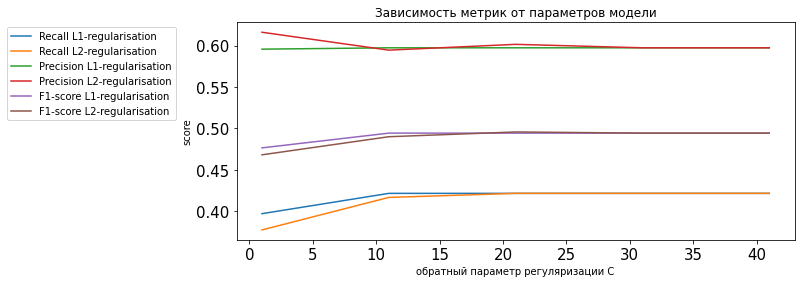

In [156]:
penalties = ['l1', 'l2']
cs = [1 + 10*i for i in range(5)]
recall_scores = []
precision_scores = []
f1_scores = []
for penalty in penalties:
    for c in cs:
        log_regs = linear_model.LogisticRegression(random_state=42, penalty=penalty, C=c, solver='liblinear')
        log_regs.fit(X_train_scaled, y_train)
        y_test_pred = log_regs.predict(X_test_scaled)
        recall_scores.append(metrics.recall_score(y_test, y_test_pred))
        precision_scores.append(metrics.precision_score(y_test, y_test_pred))
        f1_scores.append(metrics.f1_score(y_test, y_test_pred))
# Визуализируем метрики
fig, ax = plt.subplots(figsize=(10, 4))
# Строим линейный график recall
ax.plot(cs, recall_scores[:5], label='Recall L1-regularisation')
ax.plot(cs, recall_scores[5:10], label='Recall L2-regularisation')
# Строим линейный график precision
ax.plot(cs, precision_scores[:5], label='Precision L1-regularisation')
ax.plot(cs, precision_scores[5:10], label='Precision L2-regularisation')
# Строим линейный график F1
ax.plot(cs, f1_scores[:5], label='F1-score L1-regularisation')
ax.plot(cs, f1_scores[5:10], label='F1-score L2-regularisation')
ax.set_title('Зависимость метрик от параметров модели')
ax.set_xlabel('обратный параметр регуляризации C')
ax.set_ylabel('score')
ax.legend(bbox_to_anchor=(-0.1, 1));

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [157]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
print('X_train', X_train_scaled_poly.shape)
print('X_test', X_test_scaled_poly.shape)
print()

log_reg_poly = linear_model.LogisticRegression(random_state=42)
log_reg_poly.fit(X_train_scaled_poly, y_train)
y_train_pred_poly = log_reg_poly.predict(X_train_scaled_poly)
y_test_pred_poly = log_reg_poly.predict(X_test_scaled_poly)
print('Метрики на тренировочных данных')
print(metrics.classification_report(y_train, y_train_pred_poly))
print()
print('Метрики на тестовых данных')
print(metrics.classification_report(y_test, y_test_pred_poly))

X_train (1881, 454)
X_test (628, 454)

Метрики на тренировочных данных
              precision    recall  f1-score   support

           0       0.81      0.92      0.87      1271
           1       0.78      0.56      0.65       610

    accuracy                           0.81      1881
   macro avg       0.80      0.74      0.76      1881
weighted avg       0.80      0.81      0.80      1881


Метрики на тестовых данных
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       424
           1       0.73      0.56      0.64       204

    accuracy                           0.79       628
   macro avg       0.77      0.73      0.74       628
weighted avg       0.78      0.79      0.78       628



> Метрика f1_score для учебной и тестовой выборки составила 0.65 и 0.64 соответственно. Т.е. преодолен установленный в задании порог 0.5, следовательно можно считать модель удовлетворительно обученной. С другой стороны, все метрики для тестовой выборки практически не отстают от метрик для учебной выборки (самое большое отличие - precision 0.78 и 0.73), таким образом нет оснований говорить о переобученности модели. 

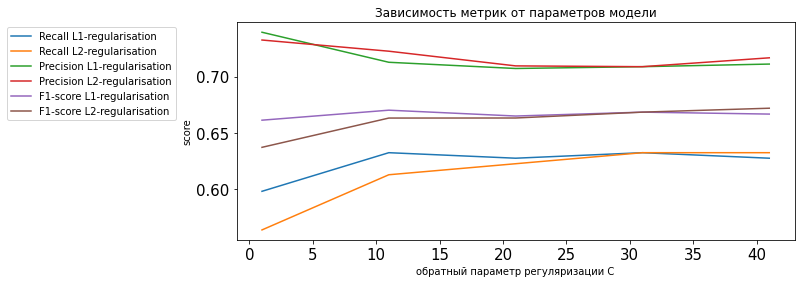

In [158]:
penalties = ['l1', 'l2']
cs = [1 + 10*i for i in range(5)]
recall_scores = []
precision_scores = []
f1_scores = []
for penalty in penalties:
    for c in cs:
        log_reg_polys = linear_model.LogisticRegression(random_state=42, penalty=penalty, C=c, solver='liblinear')
        log_reg_polys.fit(X_train_scaled_poly, y_train)
        y_test_pred_poly = log_reg_polys.predict(X_test_scaled_poly)
        recall_scores.append(metrics.recall_score(y_test, y_test_pred_poly))
        precision_scores.append(metrics.precision_score(y_test, y_test_pred_poly))
        f1_scores.append(metrics.f1_score(y_test, y_test_pred_poly))
# Визуализируем метрики
fig, ax = plt.subplots(figsize=(10, 4))
# Строим линейный график recall
ax.plot(cs, recall_scores[:5], label='Recall L1-regularisation')
ax.plot(cs, recall_scores[5:10], label='Recall L2-regularisation')
# Строим линейный график precision
ax.plot(cs, precision_scores[:5], label='Precision L1-regularisation')
ax.plot(cs, precision_scores[5:10], label='Precision L2-regularisation')
# Строим линейный график F1
ax.plot(cs, f1_scores[:5], label='F1-score L1-regularisation')
ax.plot(cs, f1_scores[5:10], label='F1-score L2-regularisation')
ax.set_title('Зависимость метрик от параметров модели')
ax.set_xlabel('обратный параметр регуляризации C')
ax.set_ylabel('score')
ax.legend(bbox_to_anchor=(-0.1, 1));

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

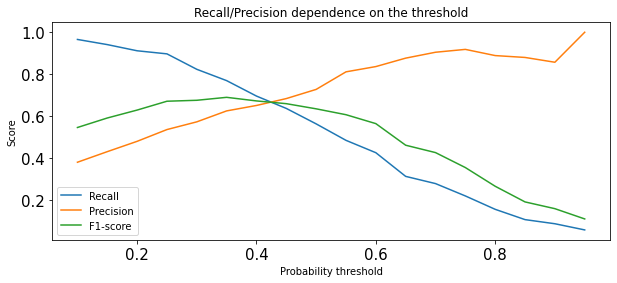

In [159]:
# Получаем вероятность класса (второй столбец)
y_test_proba_pred = log_reg_poly.predict_proba(X_test_scaled_poly)[:, 1]
# Заворачиваем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
# Создаем списки для значений метрик 
recall_scores = []
precision_scores = []
f1_scores = []
# Вероятностные пороги в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
# Перебираем сгенерированные пороги
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4))
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [160]:
# Задаем порог вероятностей, соответствующий максимальному значению f1-score
threshold_opt = 0.35
# Клиентов, для которых порог вероятности больше 0.35 относим к классу 1
# Ниже порога вероятности - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       424
           1       0.63      0.77      0.69       204

    accuracy                           0.78       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.78      0.78       628



> Максимальный f1-score для логистической регрессии, обученной на полиномиальных признаках, составил 0.69, это значение достигается при пороге вероятности равном 0.35

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [161]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [162]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [163]:
dt_cl = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий эффективности
    max_depth=None, # максимальная глубина дерева
    random_state=42
)
# Обучаем модель по алгоритму CART
dt_cl.fit(X_train, y_train)

# Предсказание класса
y_pred_train = dt_cl.predict(X_train)
y_pred_test = dt_cl.predict(X_test)
print('Метрики на тренировочных данных')
print(metrics.classification_report(y_train, y_pred_train))
print()
print('Метрики на тестовых данных')
print(metrics.classification_report(y_test, y_pred_test))

Метрики на тренировочных данных
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881


Метрики на тестовых данных
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       424
           1       0.59      0.55      0.57       204

    accuracy                           0.73       628
   macro avg       0.69      0.68      0.69       628
weighted avg       0.72      0.73      0.73       628



> f1-score на учебной выборке равен 1, а на тестовой выборке 0.57, что говорит о переобучении модели.
>
> Т.е. без ограничения количества рекурсий по глубине и по количеству объектов в листе модель идеально подстроилась под выборку, на которой она обучалась. К сожалению, на других выборках модель показывает не самый хороший результат.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [164]:
dt_cl8 = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий эффективности
    max_depth=8, # максимальная глубина дерева
    min_samples_leaf=10, # минимальное число объектов в листе
    random_state=42
)
# Обучаем модель
dt_cl8.fit(X_train, y_train)

# Предсказание класса
y_pred_train8 = dt_cl8.predict(X_train)
y_pred_test8 = dt_cl8.predict(X_test)
print('Метрики на тренировочных данных')
print(metrics.classification_report(y_train, y_pred_train8))
print()
print('Метрики на тестовых данных')
print(metrics.classification_report(y_test, y_pred_test8))

Метрики на тренировочных данных
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1271
           1       0.80      0.65      0.72       610

    accuracy                           0.83      1881
   macro avg       0.82      0.79      0.80      1881
weighted avg       0.83      0.83      0.83      1881


Метрики на тестовых данных
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       424
           1       0.71      0.58      0.64       204

    accuracy                           0.79       628
   macro avg       0.76      0.73      0.74       628
weighted avg       0.78      0.79      0.78       628



> Получена модель с удовлетворительным качеством: f1-score 0.72 на учебной и 0.64 на тестовой выборках. С одной стороны, требуемый порог точности предсказания класса преодолен, с другой - есть переобучение (подстраивание под обучающую выборку). Можно пробовать настраивать параметры глубины обучения модели, чтобы за счет возможного снижения f1 для train еще немного повысить метрику для других выборок.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [166]:
# Создаём объект класса случайный лес
rf_cl = ensemble.RandomForestClassifier(
    n_estimators=500, # число деревьев
    criterion='entropy', # критерий эффективности
    max_depth=8, # максимальная глубина дерева
    min_samples_leaf=10, # минимальное число объектов в листе
    max_features='sqrt', # число признаков из метода случайных подространств
    random_state=42 # генератор случайных чисел
)
# Обучаем модель 
rf_cl.fit(X_train, y_train)
# Предсказание класса
y_pred_ftrain = rf_cl.predict(X_train)
y_pred_ftest = rf_cl.predict(X_test)
print('Метрики на тренировочных данных')
print(metrics.classification_report(y_train, y_pred_ftrain))
print()
print('Метрики на тестовых данных')
print(metrics.classification_report(y_test, y_pred_ftest))

Метрики на тренировочных данных
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1271
           1       0.86      0.64      0.74       610

    accuracy                           0.85      1881
   macro avg       0.85      0.80      0.82      1881
weighted avg       0.85      0.85      0.84      1881


Метрики на тестовых данных
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       424
           1       0.75      0.58      0.66       204

    accuracy                           0.80       628
   macro avg       0.78      0.74      0.76       628
weighted avg       0.80      0.80      0.79       628



> f1-score 0.74 на учебной и 0.66 на тестовой выборках выше, чем полученные при обучении одного дерева. Но абсолютная разница в показателях осталась такой же, т.е. остались признаки переобучения.
>
> Видно, что улучшение предсказания на тестовой выборке произошло за счет улучшения метрики precision (улучшилась с 0.71 до 0.75 ), а recall так и остался 0.58. Таким образом, модель еще лучше исключает ложноположительные результаты, а с ложноотрицательными (т.е. с невыявленными случаями возможного ухода клиентов) модель справляется не очень хорошо.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

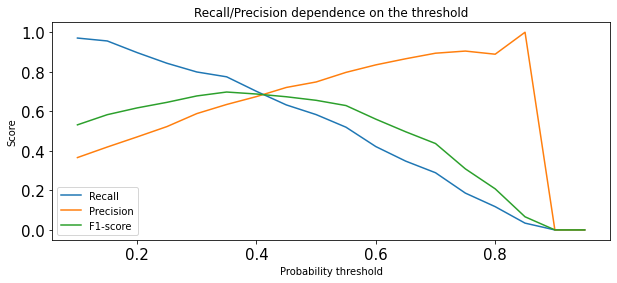

In [167]:
# Получаем вероятность класса (второй столбец)
y_pred_ftest_proba = rf_cl.predict_proba(X_test)[:, 1]
# Заворачиваем numpy-массив в pandas Series
y_pred_ftest_proba = pd.Series(y_pred_ftest_proba)
# Создаем списки для значений метрик 
recall_scores = []
precision_scores = []
f1_scores = []
# Вероятностные пороги в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
# Перебираем сгенерированные пороги
for threshold in thresholds:
    y_pred_ftest = y_pred_ftest_proba.apply(lambda x: 1 if x > threshold else 0)
    # Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_pred_ftest))
    precision_scores.append(metrics.precision_score(y_test, y_pred_ftest))
    f1_scores.append(metrics.f1_score(y_test, y_pred_ftest))
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4))
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [175]:
# Задаем порог вероятностей, соответствующий максимальному значению f1-score
threshold_opt = 0.35
# Клиентов, для которых порог вероятности больше 0.35 относим к классу 1
# Ниже порога вероятности - к классу 0
y_pred_ftest_opt = y_pred_ftest_proba.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(metrics.classification_report(y_test, y_pred_ftest_opt))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       424
           1       0.63      0.77      0.70       204

    accuracy                           0.78       628
   macro avg       0.76      0.78      0.76       628
weighted avg       0.80      0.78      0.79       628



> За счет оптимизации пороговой вероятности получилось определить для тестовой выборки метки классов с f1-score равным 0.70, т.е. еще улучшить качество модели. По графику видно, что данный результат получен за счет смещения в область, где метрика precision показывает результат хуже (0.63 вместо 0.75 при пороговой вероятности 0.5), зато увеличился показатель recall с 0.58 до 0.77.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [185]:
V_data = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
# Наилучший результат показала модель Random Forest с пороговой вероятностью 0.35.
# Для преобразования данных к формату учебной выборки добавляем дополнительные признаки, кодируем Gender
# Масштабирование и полиномиальные признаки для модели Random Forest не применялись
V_data = pd.DataFrame(V_data)
V_data['BalanceSalaryRatio'] = V_data['Balance'] / V_data['EstimatedSalary']
V_data['TenureByAge'] = V_data['Tenure'] / V_data['Age']
V_data['CreditScoreGivenAge'] = V_data['CreditScore'] / V_data['Age']
V_data['Gender'] = V_data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
# Получаем вероятность для Василия быть отнесенным к классу 1 и сравниваем ее с пороговой
print('вероятность', round(pV := rf_cl.predict_proba(V_data)[:, 1][0], 2)) 
y_Vpred = 1 if pV else 0
print('класс Василия с точки зрения риска ухода из банка', y_Vpred)

вероятность 0.61
класс Василия с точки зрения риска ухода из банка 1
